# MLP GenCode 
MLP_GenCode_trying to fix bugs.  
NEURONS=128 and K={1,2,3}.  


In [1]:
import time
def show_time():
    t = time.time()
    print(time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t)))
show_time()

2021-07-20 15:56:35 EDT


In [2]:
PC_TRAINS=100 # 8000
NC_TRAINS=100 # 8000
PC_TESTS=10 # 8000
NC_TESTS=10 # 8000   
PC_LENS=(200,99000)
NC_LENS=(200,99000)    
PC_LENS=(200,4000)
NC_LENS=(200,4000)   
MAX_K = 3 
INPUT_SHAPE=(None,84)  # 4^3 + 4^2 + 4^1
NEURONS=128
DROP_RATE=0.01
EPOCHS=100 # 1000 # 200
SPLITS=5
FOLDS=1   # make this 5 for serious testing

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Flatten,TimeDistributed
from keras.losses import BinaryCrossentropy
from keras.callbacks import ModelCheckpoint
from keras.models import load_model



In [4]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/GenCodeTools.py')
    with open('GenCodeTools.py', 'w') as f:
        f.write(r.text)  
    from GenCodeTools import GenCodeLoader
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/KmerTools.py')
    with open('KmerTools.py', 'w') as f:
        f.write(r.text)  
    from KmerTools import KmerTools
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.GenCodeTools import GenCodeLoader
        from SimTools.KmerTools import KmerTools
BESTMODELPATH=DATAPATH+"BestModel-112"  # saved on cloud instance and lost after logout
LASTMODELPATH=DATAPATH+"LastModel-112"  # saved on Google Drive but requires login

CoLab not working. On my PC, use relative paths.


## Data Load
Restrict mRNA to those transcripts with a recognized ORF.

In [5]:
PC_FILENAME='gencode.v26.pc_transcripts.fa.gz'
NC_FILENAME='gencode.v26.lncRNA_transcripts.fa.gz'
PC_FILENAME='gencode.v38.pc_transcripts.fa.gz'
NC_FILENAME='gencode.v38.lncRNA_transcripts.fa.gz'
PC_FULLPATH=DATAPATH+PC_FILENAME
NC_FULLPATH=DATAPATH+NC_FILENAME

In [6]:
loader=GenCodeLoader()
loader.set_label(1)
loader.set_check_utr(False)
pcdf=loader.load_file(PC_FULLPATH)
print("PC seqs loaded:",len(pcdf))
loader.set_label(0)
loader.set_check_utr(False)
ncdf=loader.load_file(NC_FULLPATH)
print("NC seqs loaded:",len(ncdf))
show_time()

PC seqs loaded: 106143
NC seqs loaded: 48752
2021-07-20 15:57:04 EDT


## Data Prep

In [7]:
def dataframe_length_filter(df,low_high):
    (low,high)=low_high
    # The pandas query language is strange, 
    # but this is MUCH faster than loop & drop.
    return df[ (df['seqlen']>=low) & (df['seqlen']<=high) ]
def dataframe_extract_sequence(df):
    return df['sequence'].tolist()

pc_all = dataframe_extract_sequence(
    dataframe_length_filter(pcdf,PC_LENS))
nc_all = dataframe_extract_sequence(
    dataframe_length_filter(ncdf,NC_LENS))

show_time()
print("PC seqs pass filter:",len(pc_all))
print("NC seqs pass filter:",len(nc_all))
# Garbage collection to reduce RAM footprint
pcdf=None
ncdf=None

2021-07-20 15:57:04 EDT
PC seqs pass filter: 88964
NC seqs pass filter: 46919


In [8]:
# Any portion of a shuffled list is a random selection
pc_train=pc_all[:PC_TRAINS] 
nc_train=nc_all[:NC_TRAINS]
pc_test=pc_all[PC_TRAINS:PC_TRAINS+PC_TESTS] 
nc_test=nc_all[NC_TRAINS:NC_TRAINS+PC_TESTS]
print("PC train, NC train:",len(pc_train),len(nc_train))
print("PC test, NC test:",len(pc_test),len(nc_test))
# Garbage collection
pc_all=None
nc_all=None
print("First PC train",pc_train[0])
print("First PC test",pc_test[0])

PC train, NC train: 100 100
PC test, NC test: 10 10
First PC train CCCAGATCTCTTCAGTTTTTATGCCTCATTCTGTGAAAATTGCTGTAGTCTCTTCCAGTTATGAAGAAGGTAACTGCAGAGGCTATTTCCTGGAATGAATCAACGAGTGAAACGAATAACTCTATGGTGACTGAATTCATTTTTCTGGGTCTCTCTGATTCTCAGGAACTCCAGACCTTCCTATTTATGTTGTTTTTTGTATTCTATGGAGGAATCGTGTTTGGAAACCTTCTTATTGTCATAACAGTGGTATCTGACTCCCACCTTCACTCTCCCATGTACTTCCTGCTAGCCAACCTCTCACTCATTGATCTGTCTCTGTCTTCAGTCACAGCCCCCAAGATGATTACTGACTTTTTCAGCCAGCGCAAAGTCATCTCTTTCAAGGGCTGCCTTGTTCAGATATTTCTCCTTCACTTCTTTGGTGGGAGTGAGATGGTGATCCTCATAGCCATGGGCTTTGACAGATATATAGCAATATGCAAGCCCCTACACTACACTACAATTATGTGTGGCAACGCATGTGTCGGCATTATGGCTGTCACATGGGGAATTGGCTTTCTCCATTCGGTGAGCCAGTTGGCGTTTGCCGTGCACTTACTCTTCTGTGGTCCCAATGAGGTCGATAGTTTTTATTGTGACCTTCCTAGGGTAATCAAACTTGCCTGTACAGATACCTACAGGCTAGATATTATGGTCATTGCTAACAGTGGTGTGCTCACTGTGTGTTCTTTTGTTCTTCTAATCATCTCATACACTATCATCCTAATGACCATCCAGCATCGCCCTTTAGATAAGTCGTCCAAAGCTCTGTCCACTTTGACTGCTCACATTACAGTAGTTCTTTTGTTCTTTGGACCATGTGTCTTTATTTATGCCTGGCCATTCCCCATCAAGTCATTAGATAAATTCCTTGCTGTATTTTATTCTGTG

In [9]:
def prepare_x_and_y(seqs1,seqs0):
    len1=len(seqs1)
    len0=len(seqs0)
    total=len1+len0
    L1=np.ones(len1,dtype=np.int8)
    L0=np.zeros(len0,dtype=np.int8)
    S1 = np.asarray(seqs1)
    S0 = np.asarray(seqs0)
    all_labels = np.concatenate((L1,L0))
    all_seqs = np.concatenate((S1,S0))  
    for i in range(0,len0):
        all_labels[i*2] = L0[i]
        all_seqs[i*2] = S0[i]
        all_labels[i*2+1] = L1[i]
        all_seqs[i*2+1] = S1[i]
    return all_seqs,all_labels  # use this to test unshuffled
    # bug in next line?
    X,y = shuffle(all_seqs,all_labels) # sklearn.utils.shuffle 
    #Doesn't fix it
    #X = shuffle(all_seqs,random_state=3) # sklearn.utils.shuffle 
    #y = shuffle(all_labels,random_state=3) # sklearn.utils.shuffle 
    return X,y
Xseq,y=prepare_x_and_y(pc_train,nc_train)
print(Xseq[:3])
print(y[:3])
# Tests:
show_time()

['GTGCACACGGCTCCCATGCGTTGTCTTCCGAGCGTCAGGCCGCCCCTACCCGTGCTTTCTGCTCTGCAGACCCTCTTCCTAGACCTCCGTCCTTTGTCCCATCGCTGCCTTCCCCTCAAGCTCAGGGCCAAGCTGTCCGCCAACCTCGGCTCCTCCGGGCAGCCCTCGCCCGGGGTGCGCCCCGGGGCAGGACCCCCAGCCCACGCCCAGGGCCCGCCCCTGCCCTCCAGCCCTACGCCTTGACCCGCTTTCCTGCGTCTCTCAGCCTACCTGACCTTGTCTTTACCTCTGTGGGCAGCTCCCTTGTGATCTGCTTAGTTCCCACCCCCCTTTAAGAATTCAATAGAGAAGCCAGACGCAAAACTACAGATATCGTATGAGTCCAGTTTTGTGAAGTGCCTAGAATAGTCAAAATTCACAGAGACAGAAGCAGTGGTCGCCAGGAATGGGGAAGCAAGGCGGAGTTGGGCAGCTCGTGTTCAATGGTTTTGTCCGCCTTCCCTGCCTCCTCTTCTGGGGGAGTTAGATCGAGTTGTAACAAGAACATGCCACTGTCTCGCTGGCTGCAGCGTGTGGTCCCCTTACCAGAGTGAGGATGCGAAGAGAAGGTGGCTGTCTGCAAACCAGGAAGAGAGCCCTCACCGGGAACCCGTCCAGCTGCCACCTTGAACTTGGACTTCCAAGCCTCCAGAACTGTGAGGGATAAATGTAT'
 'CCCAGATCTCTTCAGTTTTTATGCCTCATTCTGTGAAAATTGCTGTAGTCTCTTCCAGTTATGAAGAAGGTAACTGCAGAGGCTATTTCCTGGAATGAATCAACGAGTGAAACGAATAACTCTATGGTGACTGAATTCATTTTTCTGGGTCTCTCTGATTCTCAGGAACTCCAGACCTTCCTATTTATGTTGTTTTTTGTATTCTATGGAGGAATCGTGTTTGGAAACCTTCTTATTGTCATAACAGTGGTATCTGACTCCCACCTTCACTCTCCCATGTAC

In [10]:
def seqs_to_kmer_freqs(seqs,max_K):
    tool = KmerTools()  # from SimTools
    empty = tool.make_dict_upto_K(max_K)
    collection = []
    for seq in seqs:
        counts = empty
        # Last param should be True when using Harvester.
        counts = tool.update_count_one_K(counts,max_K,seq,True)
        # Given counts for K=3, Harvester fills in counts for K=1,2.
        counts = tool.harvest_counts_from_K(counts,max_K)
        fdict = tool.count_to_frequency(counts,max_K)
        freqs = list(fdict.values())
        collection.append(freqs)
    return np.asarray(collection)
Xfrq=seqs_to_kmer_freqs(Xseq,MAX_K)
print(Xfrq[:3])
show_time()

[[0.19241573 0.33146067 0.25421348 0.22191011 0.04781997 0.04219409
  0.07735584 0.02531646 0.06329114 0.1350211  0.04500703 0.08860759
  0.05625879 0.08157525 0.0604782  0.05625879 0.02531646 0.07313643
  0.07032349 0.05203938 0.0084507  0.01126761 0.01830986 0.00985915
  0.0084507  0.02112676 0.0056338  0.00704225 0.02676056 0.02253521
  0.01408451 0.01408451 0.0056338  0.0056338  0.00985915 0.0028169
  0.01549296 0.01126761 0.03239437 0.00422535 0.02676056 0.04788732
  0.01830986 0.04225352 0.00422535 0.01830986 0.00985915 0.01267606
  0.0084507  0.02957746 0.02535211 0.02535211 0.01971831 0.01126761
  0.01830986 0.00704225 0.01549296 0.03521127 0.00985915 0.02112676
  0.01408451 0.01690141 0.02253521 0.00704225 0.00422535 0.02112676
  0.01971831 0.01126761 0.00422535 0.0084507  0.0084507  0.00422535
  0.01267606 0.03098592 0.01126761 0.01830986 0.01126761 0.02394366
  0.01408451 0.02112676 0.00704225 0.01690141 0.01549296 0.01267606]
 [0.27574257 0.23589109 0.20346535 0.28490099 0.

## Neural network

In [11]:
def make_DNN():
    dt=np.float32
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt))  # relu doesn't work as well
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt)) 
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=dt))   
    dnn.compile(optimizer='adam',    # adadelta doesn't work as well
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE) 
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (None, 84)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               10880     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 27,521
Trainable params: 27,521
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    #mycallbacks = [ModelCheckpoint(
    #    filepath=MODELPATH, save_best_only=True, 
    #    monitor='val_accuracy', mode='max')]   
    # When shuffle=True, the valid indices are a random subset.
    splitter = KFold(n_splits=SPLITS,shuffle=True) 
    model = None
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    # callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()
    return model  # parameters at end of training

2021-07-20 15:57:05 EDT
MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/100
5/5 [==============================] - 21s 165ms/step - loss: 0.6963 - accuracy: 0.5058 - val_loss: 0.6899 - val_accuracy: 0.5500
Epoch 2/100
5/5 [==============================] - 0s 15ms/step - loss: 0.6987 - accuracy: 0.4495 - val_loss: 0.6983 - val_accuracy: 0.4500
Epoch 3/100
5/5 [==============================] - 0s 11ms/step - loss: 0.7071 - accuracy: 0.4633 - val_loss: 0.6914 - val_accuracy: 0.5500
Epoch 4/100
5/5 [==============================] - 0s 11ms/step - loss: 0.7026 - accuracy: 0.3761 - val_loss: 0.7090 - val_accuracy: 0.4500
Epoch 5/100
5/5 [==============================] - 0s 26ms/step - loss: 0.6925 - accuracy: 0.5462 - val_loss: 0.7010 - val_accuracy: 0.4500
Epoch 6/100
5/5 [==============================] - 0s 11ms/step - loss: 0.7038 - accuracy: 0.4537 - val_loss: 0.6891 - val_accuracy: 0.5500
Epoch 7/100
5/5 [==============================] - 0s 12ms/step - loss: 0.7018 - accuracy: 

Epoch 59/100
5/5 [==============================] - 0s 9ms/step - loss: 0.6995 - accuracy: 0.4905 - val_loss: 0.6976 - val_accuracy: 0.4500
Epoch 60/100
5/5 [==============================] - 0s 11ms/step - loss: 0.6887 - accuracy: 0.5792 - val_loss: 0.6968 - val_accuracy: 0.4500
Epoch 61/100
5/5 [==============================] - 0s 10ms/step - loss: 0.6909 - accuracy: 0.5225 - val_loss: 0.6942 - val_accuracy: 0.4500
Epoch 62/100
5/5 [==============================] - 0s 10ms/step - loss: 0.6978 - accuracy: 0.4803 - val_loss: 0.6940 - val_accuracy: 0.4500
Epoch 63/100
5/5 [==============================] - 0s 8ms/step - loss: 0.6945 - accuracy: 0.4684 - val_loss: 0.6973 - val_accuracy: 0.4500
Epoch 64/100
5/5 [==============================] - 0s 10ms/step - loss: 0.6963 - accuracy: 0.5112 - val_loss: 0.7045 - val_accuracy: 0.4500
Epoch 65/100
5/5 [==============================] - 0s 10ms/step - loss: 0.6931 - accuracy: 0.5477 - val_loss: 0.6959 - val_accuracy: 0.4500
Epoch 66/100
5/

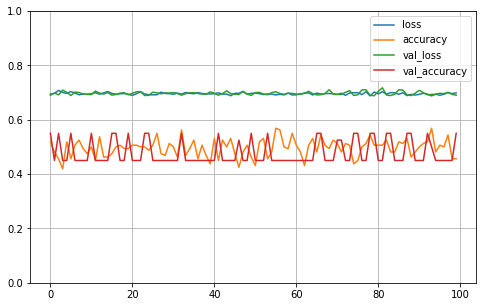

In [13]:
show_time()
last_model = do_cross_validation(Xfrq,y)

In [14]:
def show_test_AUC(model,X,y):
    ns_probs = [0 for _ in range(len(y))]
    bm_probs = model.predict(X)
    ns_auc = roc_auc_score(y, ns_probs)
    bm_auc = roc_auc_score(y, bm_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
    plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
    plt.title('ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    print("%s: %.2f%%" %('AUC',bm_auc*100.0))
def show_test_accuracy(model,X,y):
    scores = model.evaluate(X, y, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


Accuracy on training data.
Prepare...
2021-07-20 15:57:33 EDT
Extract K-mer features...
2021-07-20 15:57:33 EDT
Plot...
2021-07-20 15:57:33 EDT


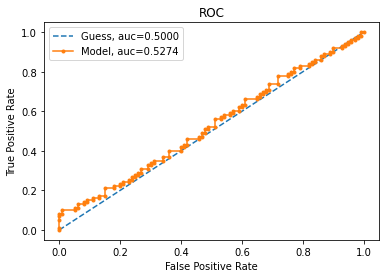

AUC: 52.74%
accuracy: 50.00%
2021-07-20 15:57:34 EDT


In [15]:
print("Accuracy on training data.")
print("Prepare...")
show_time()
Xseq,y=prepare_x_and_y(pc_train,nc_train)
print("Extract K-mer features...")
show_time()
Xfrq=seqs_to_kmer_freqs(Xseq,MAX_K)
print("Plot...")
show_time()
show_test_AUC(last_model,Xfrq,y)
show_test_accuracy(last_model,Xfrq,y)
show_time()

Accuracy on test data.
Prepare...
2021-07-20 15:57:34 EDT
Extract K-mer features...
2021-07-20 15:57:34 EDT
Plot...
2021-07-20 15:57:34 EDT


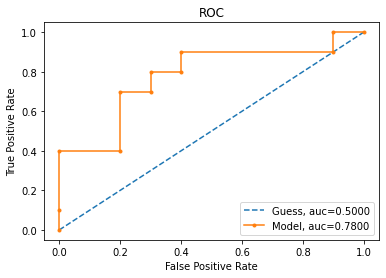

AUC: 78.00%
accuracy: 50.00%
2021-07-20 15:57:35 EDT


In [16]:
print("Accuracy on test data.")
print("Prepare...")
show_time()
Xseq,y=prepare_x_and_y(pc_test,nc_test)
print("Extract K-mer features...")
show_time()
Xfrq=seqs_to_kmer_freqs(Xseq,MAX_K)
print("Plot...")
show_time()
show_test_AUC(last_model,Xfrq,y)
show_test_accuracy(last_model,Xfrq,y)
show_time()